<a href="https://colab.research.google.com/github/stableminded/Sync-Interns-Tasks/blob/Task_2/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation , Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization ,LeakyReLU, PReLU
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# uploading dataset [ uploading the kaagle json file , it is the api key for kaggle to automatically install the dataset]
files.upload()

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"]="/content"

In [ ]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

100% 207M/207M [00:11<00:00, 19.5MB/s]
100% 207M/207M [00:11<00:00, 18.7MB/s]


In [ ]:
with zipfile.ZipFile("/content/covid-face-mask-detection-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
for dirpath,dirnames,filenames in os.walk("/content/New Masks Dataset"):
  print(f"There are{len(dirnames)} directories and {len(filenames)}images in'{dirpath}'.")

There are3 directories and 0images in'/content/New Masks Dataset'.
There are2 directories and 0images in'/content/New Masks Dataset/Test'.
There are0 directories and 50images in'/content/New Masks Dataset/Test/Mask'.
There are0 directories and 50images in'/content/New Masks Dataset/Test/Non Mask'.
There are2 directories and 0images in'/content/New Masks Dataset/Train'.
There are0 directories and 300images in'/content/New Masks Dataset/Train/Mask'.
There are0 directories and 300images in'/content/New Masks Dataset/Train/Non Mask'.
There are2 directories and 0images in'/content/New Masks Dataset/Validation'.
There are0 directories and 153images in'/content/New Masks Dataset/Validation/Mask'.
There are0 directories and 153images in'/content/New Masks Dataset/Validation/Non Mask'.


In [ ]:
def view_image(target_dir,target_class):
  target_folder=target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)
  print(random_image)
  img=mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"image shape {img.shape}")

['212.jpg']
image shape (418, 300, 3)


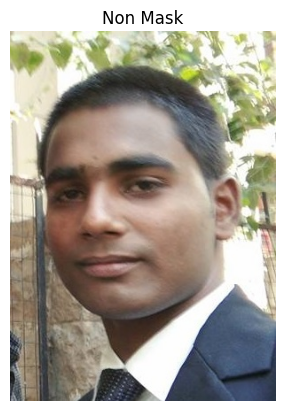

In [ ]:
view_image("/content/New Masks Dataset/Train/","Non Mask")

['0760.jpg']
image shape (683, 1024, 3)


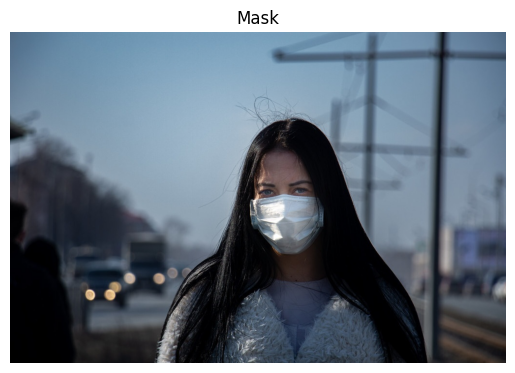

In [ ]:
view_image("/content/New Masks Dataset/Train/","Mask")

In [ ]:
data=[]
labels=[]

In [ ]:
nomask=os.listdir("/content/New Masks Dataset/Train/Non Mask/")
for i in nomask:
  image=cv2.imread("/content/New Masks Dataset/Train/Non Mask/"+i)
  image=cv2.resize(image,(224,224))
  data.append(image)
  labels.append(0)

In [ ]:
mask=os.listdir("/content/New Masks Dataset/Train/Mask/")
for i in mask:
  image=cv2.imread("/content/New Masks Dataset/Train/Mask/"+i)
  image=cv2.resize(image,(224,224))
  data.append(image)
  labels.append(1)

In [ ]:
data=np.array(data)/255.0
"""
this is to make sure that training time is faster and dividing y 255 is because
highest pixel value is 255 so after this every pixel value will either be between 0 and 1
"""


labels=np.array(labels)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.25,random_state=45,shuffle=True,stratify=labels)

In [ ]:
#using transfer learning and adding own custom layers to modify the output which is in most cases , beneficial.
base_model=tf.keras.applications.MobileNetV2(input_shape=[224,224,3],weights='imagenet',include_top=False)
#scaling and bias in the normalization layers is now handled by imagenet

for layer in base_model.layers:
  layer.trainable=False

model=Flatten()(base_model.output)
model=Dense(units=256,activation='relu')(model)
model=Dense(units=128,activation='relu')(model)
model=LeakyReLU(alpha=0.1)(model) #adding a leaky reul to tackle with the dying relu problem of dense layers above
model=PReLU()(model) #now adding parametric relu to let it work out the slope of activation parameter itself using the parameters it introduces
prediction_layer=Dense(units=1,activation='sigmoid')(model)
model=Model(inputs = base_model.input , outputs = prediction_layer )
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
model.fit(X_train,y_train,epochs=36,batch_size=36)

Epoch 1/36
13/13 [==============================] - 14s 97ms/step - loss: 2.8425 - accuracy: 0.8600
Epoch 2/36
13/13 [==============================] - 1s 57ms/step - loss: 0.1870 - accuracy: 0.9733
Epoch 3/36
13/13 [==============================] - 1s 57ms/step - loss: 0.0177 - accuracy: 0.9978
Epoch 4/36
13/13 [==============================] - 1s 65ms/step - loss: 1.2345e-06 - accuracy: 1.0000
Epoch 5/36
13/13 [==============================] - 1s 63ms/step - loss: 8.1505e-07 - accuracy: 1.0000
Epoch 6/36
13/13 [==============================] - 1s 61ms/step - loss: 6.0439e-07 - accuracy: 1.0000
Epoch 7/36
13/13 [==============================] - 1s 58ms/step - loss: 4.2634e-07 - accuracy: 1.0000
Epoch 8/36
13/13 [==============================] - 1s 62ms/step - loss: 3.7042e-07 - accuracy: 1.0000
Epoch 9/36
13/13 [==============================] - 1s 61ms/step - loss: 3.0206e-07 - accuracy: 1.0000
Epoch 10/36
13/13 [==============================] - 1s 62ms/step - loss: 2.4836e-07

In [ ]:
predictions=model.predict(X_test)
predictions

5/5 [==============================] - 2s 165ms/step


array([[0.0000000e+00],
       [1.7265066e-31],
       [5.9349981e-26],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [9.9907267e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.5399230e-37],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.0655316e-36],
       [0.0000000e+00],
       [1.0000000e+00],
       [5.2789224e-17],
       [3.3292314e-34],
       [1.0000000e+00],
       [9.5331406e-26],
       [1.5121381e-15],
       [1.0000000e+00],
       [8.8294605e-28],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0953460e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.000000

In [ ]:
predict=[]
for i in range(len(predictions)):
  if predictions[i][0]>0.5:
    predict.append(1)
  else:
    predict.append(0)

In [ ]:
pd.DataFrame(confusion_matrix(y_test,predict) , columns = ["No Mask" , "Mask"],index=["No Mask","Mask"])

,No Mask,Mask
No Mask,72,3
Mask,0,75
